In [1]:
from PIL import Image
import numpy as np
import torch
from diffusers import StableDiffusionInpaintPipeline,DDIMScheduler,DPMSolverMultistepScheduler
from torchvision.io import read_image, ImageReadMode
from masactrl.masactrl import MutualSelfAttentionControlMask_inp
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
import torch.nn.functional as F

/home/user01/.conda/envs/pytorch2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_path = "/home/user01/MyREMOVAL/examples/img/an.png"
mask_image_path = "/home/user01/MyREMOVAL/examples/mask/an_mask.png"
prompts = ""

In [3]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
#scheduler = DPMSolverMultistepScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",solver_order=3)
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "/home/user01/SD2-1-base",
    scheduler=scheduler,
    torch_dtype=torch.float32,  
)
pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 14.08it/s]
/home/user01/.conda/envs/pytorch2/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_inpaint.py:290: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloa

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "/home/user01/SD2-1-base",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
def load_mask(mask_path):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (512, 512))
    mask = mask.to(torch.float32)
    #mask = mask.half()
    return mask

test_mask = load_mask(mask_image_path)
# inference the synthesized image with MasaCtrl
START_STEP = 0
END_STEP = 50
LAYER = 6 #0~5down,6mid,7~15up
END_LAYER = 16

# hijack the attention module
editor = MutualSelfAttentionControlMask_inp(START_STEP, END_STEP, LAYER, END_LAYER, mask=test_mask)
regiter_attention_editor_diffusers(pipe, editor)

AN at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
AN at U-Net layers:  [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Using mask-guided AN


In [5]:
image_s = Image.open(image_path).convert('RGB')
mask = Image.open(mask_image_path)
seed=775
g = torch.Generator('cuda').manual_seed(seed)

100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


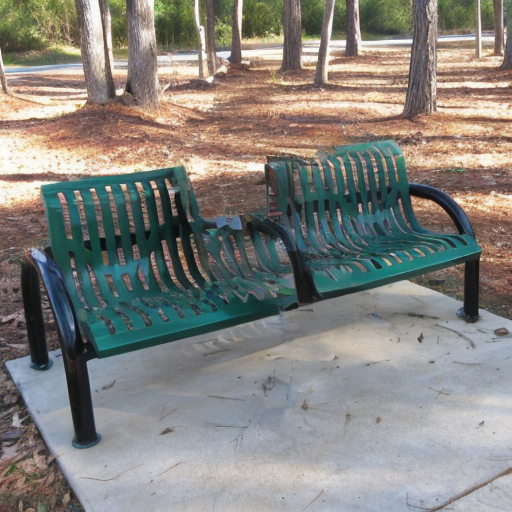

In [6]:
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image = pipe(prompt=prompts, image=image_s, mask_image=mask,num_inference_steps = 50,strength=1,generator=g, guidance_scale = 1).images[0]
image.save("/home/user01/sd_inp/result.png")
image

In [7]:
ori_image = Image.open(image_path)
dior_array = np.array(ori_image)
dior_tensor = torch.tensor(dior_array)
dior_tensor.size()

torch.Size([512, 512, 4])

In [8]:
mask_array = np.array(mask)
mask_tensor = torch.tensor(mask_array)
mask_tensor.size()

torch.Size([512, 512, 4])